In [42]:
# 一、准备数据

# imdb数据集的目标是根据电影评论的文本内容预测评论的情感标签。

# 训练集有20000条电影评论文本，测试集有5000条电影评论文本，

# 其中正面评论和负面评论都各占一半。 

# 文本数据预处理较为繁琐，

# 包括中文切词（本示例不涉及），

# 构建词典，编码转换，序列填充，构建数据管道等等。 

# 在torch中预处理文本数据一般使用torchtext或者自定义Dataset，

# torchtext功能非常强大，可以构建文本分类，序列标注，问答模型，机器翻译等NLP任务的数据集。

# torchtext常见API一览：

# torchtext.data.Example : 用来表示一个样本，数据和标签 
    
# torchtext.vocab.Vocab: 词汇表，可以导入一些预训练词向量 
    
# torchtext.data.Datasets: 数据集类，__getitem__返回 Example实例, 
    
# torchtext.data.TabularDataset是其子类。 

# torchtext.data.Field : 用来定义字段的处理方法（文本字段，标签字段）创建 Example时的 预处理，batch 时的一些处理操作。
    
# torchtext.data.Iterator: 迭代器，用来生成 batch 
    
# torchtext.datasets: 包含了常见的数据集。
        
import torch
import string, re
import torchtext

# 仅考虑最高频的10000个词
MAX_WORDS = 10000
# 每个样本保留200个词的长度
MAX_LEN = 200
BATCH_SIZE = 20

# 分词方法
tokenizer = lambda x:re.sub('[%s]'%string.punctuation,"",x).split(" ")

# 过滤掉低频词
def filterLowFreqWords(arr, vocabs):
    arr = [[x if x<MAX_WORDS else 0 for x in example]
          for example in arr]
    return arr

# 1. 定义各个字段的预处理方法
TEXT = torchtext.legacy.data.Field(sequential=True, tokenize=tokenizer, lower=True,
                            fix_length=MAX_LEN,postprocessing = filterLowFreqWords)
LABEL = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

# 2.构建表格型dataset
 #torchtext.data.TabularDataset可读取csv,tsv,json等格式
ds_train, ds_test = torchtext.legacy.data.TabularDataset.splits(       
        path='../data/imdb', train='train.tsv',test='test.tsv', format='tsv',        
        fields=[('label', LABEL), ('text', TEXT)],skip_header = False)

# 3. 构建词典
TEXT.build_vocab(ds_train) 

# 4. 构建数据管道迭代器
train_iter, test_iter = torchtext.legacy.data.Iterator.splits(        
    (ds_train, ds_test),  sort_within_batch=True,sort_key=lambda x: len(x.text),        
    batch_sizes=(BATCH_SIZE,BATCH_SIZE))

#查看example信息 
print(ds_train[0].text) 
print(ds_train[0].label)

['it', 'really', 'boggles', 'my', 'mind', 'when', 'someone', 'comes', 'across', 'a', 'movie', 'like', 'this', 'and', 'claims', 'it', 'to', 'be', 'one', 'of', 'the', 'worst', 'slasher', 'films', 'out', 'there', 'this', 'is', 'by', 'far', 'not', 'one', 'of', 'the', 'worst', 'out', 'there', 'still', 'not', 'a', 'good', 'movie', 'but', 'not', 'the', 'worst', 'nonetheless', 'go', 'see', 'something', 'like', 'death', 'nurse', 'or', 'blood', 'lake', 'and', 'then', 'come', 'back', 'to', 'me', 'and', 'tell', 'me', 'if', 'you', 'think', 'the', 'night', 'brings', 'charlie', 'is', 'the', 'worst', 'the', 'film', 'has', 'decent', 'camera', 'work', 'and', 'editing', 'which', 'is', 'way', 'more', 'than', 'i', 'can', 'say', 'for', 'many', 'more', 'extremely', 'obscure', 'slasher', 'filmsbr', 'br', 'the', 'film', 'doesnt', 'deliver', 'on', 'the', 'onscreen', 'deaths', 'theres', 'one', 'death', 'where', 'you', 'see', 'his', 'pruning', 'saw', 'rip', 'into', 'a', 'neck', 'but', 'all', 'other', 'deaths', 'a

In [43]:
print(len(TEXT.vocab))

# index转换成string类型
print(TEXT.vocab.itos[0])
print(TEXT.vocab.itos[1])

# string转换成index
# 未知词
print(TEXT.vocab.stoi['<unk>'])
# padding填充
print(TEXT.vocab.stoi['<pad>'])

# freqs词频
print(TEXT.vocab.freqs['<unk>'])
print(TEXT.vocab.freqs['a'])
print(TEXT.vocab.freqs['good'])


108197
<unk>
<pad>
0
1
0
129453
11457


In [44]:
# 查看数据管道信息
# 注意text第0维度是句子长度

for batch in train_iter:
    features = batch.text
    labels = batch.label
    print(features)
    print(features.shape)
    print(labels)
    break
    

tensor([[  62,    0,   75,  ...,  220,   75,   11],
        [  82,    3,   11,  ...,   99,  217,    7],
        [  23, 1980,   18,  ...,    5,   58,   29],
        ...,
        [ 208,    0,    4,  ...,    1,    1,    1],
        [2120,    0,    0,  ...,    1,    1,    1],
        [ 171,   37,    8,  ...,    1,    1,    1]])
torch.Size([200, 20])
tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0])


In [45]:
# 将数据管道组织成torch.utils.data.DataLoader相似的features,label输出形式

class DataLoader:
    def __init__(self,data_iter):
        self.data_iter = data_iter
        self.length = len(data_iter)
    def __len__(self):
        return self.length
    def __iter__(self):
#         此处调整features为batch first
#         并调整label的shape和dtype
        for batch in self.data_iter:
            yield(torch.transpose(batch.text,0,1),
                 torch.unsqueeze(batch.label.float(), dim = 1))
dl_train = DataLoader(train_iter)
dl_test = DataLoader(test_iter)

In [46]:
# 二、定义模型

# 使用Pytorch通常有三种方式构建模型：
# 使用nn.Sequential按层顺序构建模型，
# 继承nn.Module 基类构建自定义模型，
# 继承nn.Module基类构建模型并辅助应用模型容器 
# (nn.Sequential,nn.ModuleList,nn.ModuleDict)进行封装。

# 由于接下来使用类形式的训练循环，
# 我们将模型封装成torchkeras.Model类来获得类似Keras中高阶模型接口的功能。 
# Model类实际上继承自nn.Module类

import torch
from torch import nn
import torchkeras
from torchkeras import LightModel,summary
torch.random.seed()
import torch
from torch import nn 
class Net(torchkeras.Model):
    def __init__(self):        
        super(Net, self).__init__()        
        #设置padding_idx参数后将在训练过程中将填充的token始终赋值为0向量        
        self.embedding = nn.Embedding(num_embeddings = MAX_WORDS,embedding_dim = 3,padding_idx = 1)        
        self.conv = nn.Sequential()        
        self.conv.add_module("conv_1",nn.Conv1d(in_channels = 3,out_channels = 16,kernel_size = 5))        
        self.conv.add_module("pool_1",nn.MaxPool1d(kernel_size = 2))        
        self.conv.add_module("relu_1",nn.ReLU())        
        self.conv.add_module("conv_2",nn.Conv1d(in_channels = 16,out_channels = 128,kernel_size = 2))        
        self.conv.add_module("pool_2",nn.MaxPool1d(kernel_size = 2))        
        self.conv.add_module("relu_2",nn.ReLU())
        self.dense = nn.Sequential()        
        self.dense.add_module("flatten",nn.Flatten())        
        self.dense.add_module("linear",nn.Linear(6144,1))        
        self.dense.add_module("sigmoid",nn.Sigmoid())
    def forward(self,x):        
        x = self.embedding(x).transpose(1,2)        
        x = self.conv(x)        
        y = self.dense(x)        
        return y
model = Net() 
print(model)
model.summary(input_shape = (200,),input_dtype = torch.LongTensor)

Net(
  (embedding): Embedding(10000, 3, padding_idx=1)
  (conv): Sequential(
    (conv_1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
    (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_1): ReLU()
    (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
    (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (dense): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=6144, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1               [-1, 200, 3]          30,000
            Conv1d-2              [-1, 16, 196]             256
         MaxPool1d-3               [-1, 16, 98]               0
              ReLU-4               [-1, 16, 98]               0
            Conv1d-5      

In [47]:
# 三，训练模型 
# 训练Pytorch通常需要用户编写自定义训练循环，
# 训练循环的代码风格因人而异。 
# 有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。
# 此处介绍一种类形式的训练循环。 
# 仿照Keras定义了一个高阶的模型接口Model,
# 实现 fit, validate，predict, summary方法，相当于用户自定义高阶API。

def accuracy(y_pred,y_true):    
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred,dtype = torch.float32),                      
                         torch.zeros_like(y_pred,dtype = torch.float32))    
    acc = torch.mean(1-torch.abs(y_true-y_pred))    
    return acc
model.compile(loss_func = nn.BCELoss(),optimizer= 
              torch.optim.Adagrad(model.parameters(),lr = 0.02),            
              metrics_dict={"accuracy":accuracy})

In [48]:
# 有时候模型训练过程中不收敛，需要多试几次 
dfhistory = model.fit(20,dl_train,dl_val=dl_test,log_step_freq= 200)

Start Training ...

================================================================================2021-09-24 19:28:17
{'step': 200, 'loss': 0.74, 'accuracy': 0.504}
{'step': 400, 'loss': 0.718, 'accuracy': 0.497}
{'step': 600, 'loss': 0.71, 'accuracy': 0.5}
{'step': 800, 'loss': 0.705, 'accuracy': 0.505}
{'step': 1000, 'loss': 0.703, 'accuracy': 0.507}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   1   | 0.703 |  0.507   |  0.692   |    0.515     |
+-------+-------+----------+----------+--------------+

================================================================================2021-09-24 19:28:25
{'step': 200, 'loss': 0.683, 'accuracy': 0.568}
{'step': 400, 'loss': 0.684, 'accuracy': 0.561}
{'step': 600, 'loss': 0.683, 'accuracy': 0.56}
{'step': 800, 'loss': 0.682, 'accuracy': 0.565}
{'step': 1000, 'loss': 0.682, 'accuracy': 0.565}

 +-------+-------+------

{'step': 400, 'loss': 0.291, 'accuracy': 0.882}
{'step': 600, 'loss': 0.294, 'accuracy': 0.881}
{'step': 800, 'loss': 0.295, 'accuracy': 0.879}
{'step': 1000, 'loss': 0.292, 'accuracy': 0.881}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   14  | 0.292 |  0.881   |  0.569   |    0.744     |
+-------+-------+----------+----------+--------------+

================================================================================2021-09-24 19:30:15
{'step': 200, 'loss': 0.279, 'accuracy': 0.888}
{'step': 400, 'loss': 0.277, 'accuracy': 0.888}
{'step': 600, 'loss': 0.276, 'accuracy': 0.888}
{'step': 800, 'loss': 0.278, 'accuracy': 0.887}
{'step': 1000, 'loss': 0.277, 'accuracy': 0.888}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   15  | 0.277 |  0.

In [34]:
# import pytorch_lightning as pl 
# from torchkeras import LightModel 

# class Model(LightModel):
    
#     #loss,and optional metrics
#     def shared_step(self,batch)->dict:
#         x, y = batch
#         prediction = self(x)
#         loss = nn.BCELoss()(prediction,y)
#         preds = torch.where(prediction>0.5,torch.ones_like(prediction),torch.zeros_like(prediction))
#         acc = pl.metrics.functional.accuracy(preds, y)
#         dic = {"loss":loss,"accuracy":acc} 
#         return dic
    
#     #optimizer,and optional lr_scheduler
#     def configure_optimizers(self):
#         optimizer= torch.optim.Adagrad(self.parameters(),lr = 0.02)
#         return optimizer

In [35]:
# pl.seed_everything(1234)
# net = Net()
# model = Model(net)

# ckpt_cb = pl.callbacks.ModelCheckpoint(monitor='val_loss')

# # set gpus=0 will use cpu，
# # set gpus=1 will use 1 gpu
# # set gpus=2 will use 2gpus 
# # set gpus = -1 will use all gpus 
# # you can also set gpus = [0,1] to use the  given gpus
# # you can even set tpu_cores=2 to use two tpus 

# trainer = pl.Trainer(max_epochs=20,gpus = 1, callbacks=[ckpt_cb]) 
# trainer.fit(model,dl_train,dl_test)

In [49]:
# 四，评估模型 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

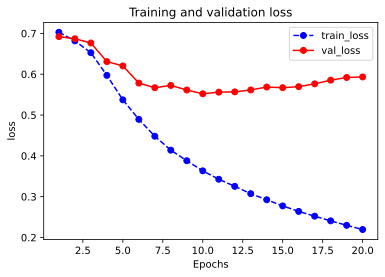

In [50]:
plot_metric(dfhistory,"loss")

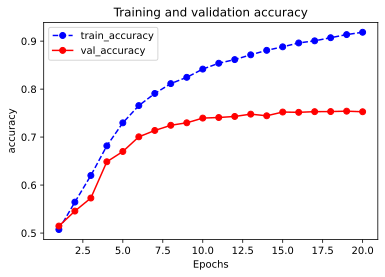

In [51]:
plot_metric(dfhistory,"accuracy")

In [53]:
# 评估
model.evaluate(dl_test)

{'val_loss': 0.5933524006605149, 'val_accuracy': 0.7527999993562698}

In [54]:
# 五，使用模型

model.predict(dl_test)

tensor([[0.1783],
        [0.9539],
        [0.6074],
        ...,
        [0.9810],
        [0.2710],
        [0.0124]])

In [55]:
# 六，保存模型

print(model.state_dict().keys())

odict_keys(['embedding.weight', 'conv.conv_1.weight', 'conv.conv_1.bias', 'conv.conv_2.weight', 'conv.conv_2.bias', 'dense.linear.weight', 'dense.linear.bias'])


In [57]:
# 保存模型参数 
torch.save(model.state_dict(), "../data/imdb/model_parameter.pkl")
model_clone = Net() 
model_clone.load_state_dict(torch.load("../data/imdb/model_parameter.pkl"))
model_clone.compile(loss_func = nn.BCELoss(),optimizer= 
                    torch.optim.Adagrad(model.parameters(),lr = 0.02),             
                    metrics_dict={"accuracy":accuracy})